In [2]:
!pip install datasets bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [77]:
from datasets import load_dataset, concatenate_datasets
from huggingface_hub import login
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer, SFTConfig
import torch

In [ ]:
login("") # Insert HF API key here

In [7]:
ro_math_bac_set = load_dataset('cosmadrian/romath', 'bac')
ro_math_comp_set = load_dataset('cosmadrian/romath', 'comps')
ro_math_synthethic_set = load_dataset('cosmadrian/romath', 'synthetic')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

romath-bac-train.csv:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

romath-bac-test.csv:   0%|          | 0.00/459k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1477 [00:00<?, ? examples/s]

romath-comps-train.csv:   0%|          | 0.00/612k [00:00<?, ?B/s]

romath-comps-test.csv:   0%|          | 0.00/246k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/804 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/329 [00:00<?, ? examples/s]

romath-deepmind-train.csv:   0%|          | 0.00/7.48M [00:00<?, ?B/s]

romath-deepmind-test.csv:   0%|          | 0.00/936k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/55944 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7100 [00:00<?, ? examples/s]

In [8]:
ro_math_bac_set_combined = concatenate_datasets([ro_math_bac_set['train'], ro_math_bac_set['test']])

In [9]:
ro_math_comp_set_combined = concatenate_datasets([ro_math_comp_set['train'], ro_math_comp_set['test']])
ro_math_synthethic_set_combined = concatenate_datasets([ro_math_synthethic_set['train'], ro_math_synthethic_set['test']])

EDA: Observing the domain distribution in the dataset
To make it easier, we have combined the train and test split to get the total number of samples belonging to a certain domain in our set

In [71]:
class DatasetAnalyzer:
  """
    A class that helps with EDA.
    Currently supports:
    - Computing domain frequency distributions for each dataset subset (bac, comps, synthetic).
    - Getting the max sequence length per set to get an idea of the max_seq_len hyperparameter for LLM fine tuning
  """

  DOMAIN_COLUMN_NAME = 'domain'
  PROBLEM_COLUMN_NAME = 'problem'


  def __init__(self, ro_math_bac_set, ro_math_comp_set, ro_math_syntethic_set):
    self.data_subsets = {
        'bac': ro_math_bac_set,
        'comps': ro_math_comp_set,
        'synthetic': ro_math_syntethic_set
    }


  def get_domain_distribution(self, subset: str):
    if subset not in self.data_subsets:
      raise ValueError("Invalid data subset")

    analyzed_subset = self.data_subsets[subset]
    return dict(Counter(analyzed_subset[self.DOMAIN_COLUMN_NAME]))

  def get_max_sequence_length(self, subset:str):
    if subset not in self.data_subsets:
      raise ValueError("Invalid data subset")

    max_len = 0
    analyzed_subset = self.data_subsets[subset]

    for problem in analyzed_subset[self.PROBLEM_COLUMN_NAME]:
      problem_length = len(problem.split())
      if problem_length > max_len:
        max_len = problem_length

    return max_len

In [72]:
class DatasetVisualizer(DatasetAnalyzer):

  """
    Inherits from DatasetAnalyzer. Adds visualization methods for domain distributions
    across BAC, COMP, and SYNTHETIC subsets.
  """

  def __init__(self, ro_math_bac_set, ro_math_comp_set, ro_math_syntethic_set):
    super().__init__(ro_math_bac_set, ro_math_comp_set, ro_math_syntethic_set)

  def visualize_domain_distributions(self):
    overall_domain_distributions = [self.get_domain_distribution(subset) for subset in self.data_subsets]

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    bar_width = 0.6
    plot_colors = ['b', 'g', 'r']

    for idx, (subset, color) in enumerate(zip(self.data_subsets, plot_colors)):
      indices_x_axis = np.arange(len(overall_domain_distributions[idx]))
      labels = list(overall_domain_distributions[idx].keys())
      max_upper_bound_domain = max(overall_domain_distributions[idx].values())

      ax[idx].bar(indices_x_axis, overall_domain_distributions[idx].values(), color = color, width = bar_width)
      ax[idx].set_title(subset.upper() + ' domain distribution')
      ax[idx].set_xticks(indices_x_axis)
      ax[idx].set_xticklabels(labels, rotation = 70)
      ax[idx].set_ylim(0, max_upper_bound_domain * 1.1)
      ax[idx].set_ylabel('Domain counter')

    fig.suptitle("Domain Distribution Across Subsets", fontsize=16)
    plt.show()

  def visualize_max_sequence_length(self):
    overall_max_seq_lengths = [self.get_max_sequence_length(subset) for subset in self.data_subsets]
    subsets = ['BAC', 'COMP', 'SYNTHETIC']

    plt.bar(subsets, overall_max_seq_lengths)
    plt.title('Maximum sequence lengths across subsets')
    plt.xlabel('Subsets')
    plt.ylabel('Maximum sequence length')
    plt.show()

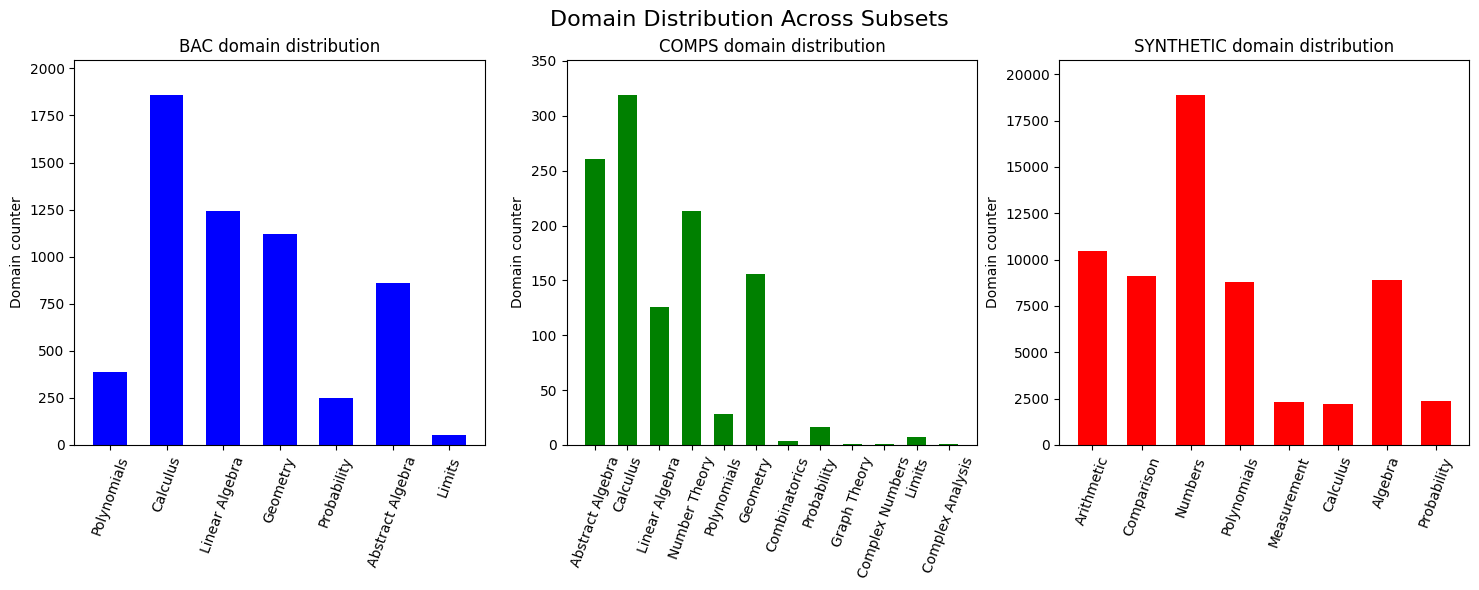

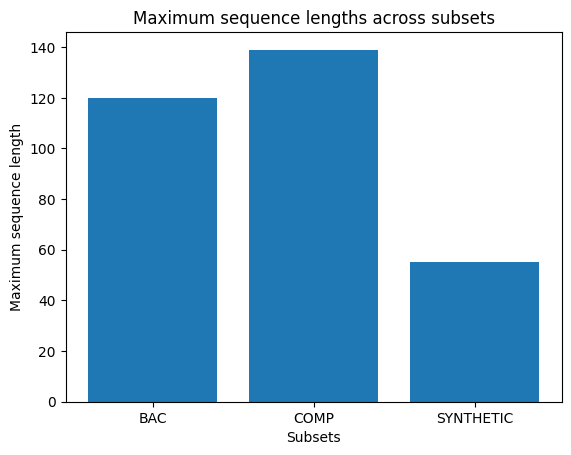

In [73]:
dataset_visualizer = DatasetVisualizer(ro_math_bac_set_combined, ro_math_comp_set_combined, ro_math_synthethic_set_combined)
dataset_visualizer.visualize_domain_distributions()
dataset_visualizer.visualize_max_sequence_length()

Loading the LLM: for the first experiment, we used RoLlama

In [26]:
# TODO: Start finetuning the model

model_name = "OpenLLM-Ro/RoLlama2-7b-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [59]:
def format_questions_answers(data_samples):
  questions_column = data_samples['problem']
  answers_column = data_samples['answer']
  formatted_texts = []

  for question, answer in zip(questions_column, answers_column):
    messages_ro_llama = [
      {"role": "system", "content": "Ești un asistent folositor, respectuos și onest. Încearcă să ajuți cât mai mult prin informațiile oferite, excluzând răspunsuri toxice, rasiste, sexiste, periculoase și ilegale."},
      {"role": "user", "content": question},
      {"role": "assistant", "content": answer}
    ]

    formatted_message = tokenizer.apply_chat_template(
        messages_ro_llama,
        tokenize = False,
        add_generation_prompt = False
    )

    formatted_texts.append(formatted_message)

  return {"text": formatted_texts}



In [68]:
ro_math_bac_set_updated = ro_math_bac_set.map(format_questions_answers, batched = True)
ro_math_comp_set_updated = ro_math_comp_set.map(format_questions_answers, batched = True)

In [80]:
peft_config = LoraConfig(
                          lora_alpha=16,
                          lora_dropout=0.1,
                          r=64,
                          bias="none",
                          task_type="CAUSAL_LM"
                        )

In [82]:
trainer = SFTTrainer(
    model = model,
    processing_class = tokenizer,
    train_dataset = ro_math_bac_set_updated['train'],
    eval_dataset = ro_math_bac_set_updated['test'],
    peft_config = peft_config,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()